<a href="https://colab.research.google.com/github/raheelam98/LangGraph/blob/main/agentic_modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

In [12]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "agentic modules"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

In [4]:
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=gemini_api_key)

In [5]:
result = llm.invoke("hi")
result

AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ab0aa0b8-6c1d-4e6b-8cc6-36d3e6ac7c61-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

#### AI Agent Paratice

**Module 1 : 2.2_chains_reducers.ipynb**

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed.

# Router
**Module 1 : 3_router.ipynb**

* Return a tool call
* Return a natural language response

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ["GEMINI_API_KEY"])
llm_with_tools = llm.bind_tools([multiply])

In [ ]:
llm_with_tools

In [7]:
# Import IPython display classes for visual representation
from IPython.display import Image, display

# Import necessary modules from langgraph.graph for building the state graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# Import CompiledStateGraph for compiling the state graph
from langgraph.graph.state import CompiledStateGraph

# Import ToolNode and tools_condition from langgraph.prebuilt
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node that will call the LLM tools
def tool_calling_llm(state: MessagesState) -> MessagesState:
    # Invoke the LLM tools with the current messages from the state and return the updated state
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build the state graph
builder: StateGraph = StateGraph(MessagesState)

# Add nodes to the graph
builder.add_node("tool_calling_llm", tool_calling_llm)  # Add tool_calling_llm node
builder.add_node("tools", ToolNode([multiply]))  # Add ToolNode for the multiply function

# Define edges for the graph
builder.add_edge(START, "tool_calling_llm")  # Start the graph with tool_calling_llm node
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,  # Route to tools or END based on the tools_condition
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
)

# Define the edge from tools to END
builder.add_edge("tools", END)

# Compile the graph to a reactive graph
graph: CompiledStateGraph = builder.compile()


In [8]:
graph

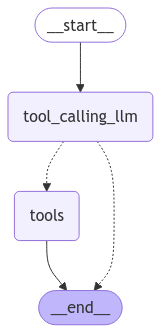

In [9]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
from langchain_core.messages import HumanMessage

# Prepare the initial message from the human
messages = [HumanMessage(content="Hello world.")]

# Invoke the graph with the prepared messages
messages = graph.invoke({"messages": messages})

# Iterate through the returned messages and print each one
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello world.


In [11]:
# Import the HumanMessage class from langchain_core.messages
from langchain_core.messages import HumanMessage

# Prepare the initial message from the human with the content "Multiply 2 and 3."
messages = [HumanMessage(content="Multiply 2 and 3.")]

# Invoke the graph with the prepared messages
messages = graph.invoke({"messages": messages})

# Iterate through the returned messages and print each one
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (3dad9700-b12b-41fc-9a76-5deec626c2f0)
 Call ID: 3dad9700-b12b-41fc-9a76-5deec626c2f0
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6


Explanation of Comments:

1 Importing HumanMessage:

from langchain_core.messages import HumanMessage: This line imports the HumanMessage class from the langchain_core.messages module.

2 Preparing the Initial Message:

messages = [HumanMessage(content="Multiply 2 and 3.")]: This line creates a list containing a single HumanMessage with the content "Multiply 2 and 3."

3 Invoking the Graph:

messages = graph.invoke({"messages": messages}): This line invokes the graph with the prepared messages. The graph processes the messages and returns the updated state.

4 Iterating and Printing Messages:

for m in messages['messages']::: This line starts a loop that iterates through the returned messages in the updated state.

m.pretty_print(): This line prints each message using the pretty_print method for a formatted output.